In [2]:
import numpy as np
import matplotlib.pyplot as plt
import zarr
import xarray as xr
import os
from sklearn import preprocessing
import torch
import math

import torch
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.utils.data as data_utils
from torch.nn import Linear, Conv1d, ConvTranspose1d

from torch.nn import Sequential as Seq, Linear as Lin, ReLU, Sigmoid, ConstantPad1d
from torch.functional import F
from torch.optim.lr_scheduler import OneCycleLR
from tqdm import tqdm

from tqdm.notebook import tqdm


## Load the data for the case

In [3]:
from models import DriverDatasetCase, VAElatentdynamics

In [54]:
case = 3 
caseloader=torch.load('/home/jovyan/neural-dsds/neural-dsds/data/case'+str(case)+'loader.pth')
mask = np.load('/home/jovyan/neural-dsds/neural-dsds/data/case'+str(case)+'mask.npy')

In [55]:
onecatfile = 'offline_singlecat_referencedetail.nc'
twocatfile = 'offline_79micron_referencedetail.nc'

In [56]:
onecatfilepath=os.path.join('/home/jovyan/neural-dsds/neural-dsds/data',onecatfile)
twocatfilepath = os.path.join('/home/jovyan/neural-dsds/neural-dsds/data',twocatfile)

In [57]:
from netCDF4 import Dataset
ds1 = Dataset(onecatfilepath)
ds2 = Dataset(twocatfilepath)

In [58]:
def inference(model,dataloader,device,nlatent):
    model.eval()
    dataset = dataloader.dataset

    ntargets = nlatent
    nmoms = 4
    nrates = 3
    bs = 500
    print(len(dataset))
    
    pred = np.zeros((len(dataset),ntargets,nrates))
    real = np.zeros((len(dataset),ntargets,nrates))
    
    #[500, 3, 3, 2]) torch.Size([500, 3, 3, 2] 
    realM = np.zeros((len(dataset),nmoms,nrates))
    realdMdt = np.zeros((len(dataset),nmoms,nrates))
    
    realbin1 = np.zeros((len(dataset),2,35))
    realbin0 = np.zeros((len(dataset),2,35))
    predbin0 = np.zeros((len(dataset),2,35))
    predbin1 = np.zeros((len(dataset),2,35))
 
    Lt0= np.zeros((len(dataset),ntargets))
    predL = np.zeros((len(dataset),ntargets))
    realL = np.zeros((len(dataset),ntargets))

    jj = 0
    i = 0

    for data in dataloader:
        M,dMdt,bin0,bin1coal,bin1condevap,binmag,M1,dM1dt,M2,dM2dt=data
        bin1 = bin1coal 
        bin0 = bin0.to(device)
        bin1 = bin1.to(device)
        binmag = binmag.to(device)
                             
        normRt0,normRt1,Lit1,Lit1_pred,binmagRt0,binmagRt1,Lit0_cond,mu0,logvar0,mu1,logvar1 = model(torch.Tensor(bin0).float(),
                        torch.Tensor(bin1).float(),binmag[:,0:2].float(),binmag[:,2:4].float())
        bs = normRt0.size(0)
        
        normbin0 = bin0.float()*torch.broadcast_to(binmag[:,0:2].float().unsqueeze(dim=2),(bs,2,35))
        normbin1 = bin1.float()*torch.broadcast_to(binmag[:,2:4].float().unsqueeze(dim=2),(bs,2,35))
        
        if normRt0 is not(None):

            realM[jj:jj+bs,:,:] = M.cpu().detach().numpy().reshape(bs,nmoms,nrates)
            realdMdt[jj:jj+bs,:,:] = dMdt.cpu().detach().numpy().reshape(bs,nmoms,nrates)
            realbin0[jj:jj+bs,:] = normbin0.cpu().detach().numpy().reshape(bs,2,35)
            realbin1[jj:jj+bs,:] = normbin1.cpu().detach().numpy().reshape(bs,2,35)
            predbin0[jj:jj+bs,:] = normRt0.cpu().detach().numpy().reshape(bs,2,35)
            predbin1[jj:jj+bs,:] = normRt1.cpu().detach().numpy().reshape(bs,2,35)
            predL[jj:jj+bs,:] = Lit1_pred.cpu().detach().numpy().reshape(bs,ntargets)
            realL[jj:jj+bs,:] = Lit1.cpu().detach().numpy().reshape(bs,ntargets)
            Lt0[jj:jj+bs,:] = Lit0_cond.cpu().detach().numpy().reshape(bs,ntargets)
            
            jj=jj+bs
            i = i+1
        else:
            break

    return realM,realdMdt,realbin0,realbin1,predbin0,predbin1,predL,realL,Lt0

In [59]:
model = VAElatentdynamics(n_bins=35,n_latent=3)


# Check if there is a gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(model)
model = model.to(device)

cuda:0
VAElatentdynamics(
  (encoder): CNNEncoderVAE(
    (conv1): Conv1d(2, 4, kernel_size=(4,), stride=(2,), padding=(1,))
    (activation1): ReLU()
    (conv2): Conv1d(4, 8, kernel_size=(4,), stride=(2,), padding=(1,))
    (activation2): ReLU()
    (conv3): Conv1d(8, 4, kernel_size=(4,), stride=(2,), padding=(1,))
    (activation3): ReLU()
    (fc_mu): Linear(in_features=16, out_features=3, bias=True)
    (fc_var): Linear(in_features=16, out_features=3, bias=True)
  )
  (decoder): CNNDecoder(
    (lin): Linear(in_features=3, out_features=16, bias=True)
    (conv1): ConvTranspose1d(4, 8, kernel_size=(4,), stride=(2,), padding=(1,))
    (activation1): ReLU()
    (constantpad1d1): ConstantPad1d(padding=(1, 0), value=0)
    (conv2): ConvTranspose1d(8, 4, kernel_size=(4,), stride=(2,), padding=(1,))
    (activation2): ReLU()
    (constantpad1d2): ConstantPad1d(padding=(1, 0), value=0)
    (conv3): ConvTranspose1d(4, 2, kernel_size=(4,), stride=(2,), padding=(1,))
    (activation3): ReLU(

In [60]:
# Load the best model weights
j = 4
epochs = 500
# Check if there is a gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = model.to(device)
mod_weights = "LatentDynamicsModels/VAELatentDynamics3var_CNN_n{}_{}epochs_Sigmoid_magnitude_expdynLin_nobias_updatedata_Li_dLdt2_c1e2".format(j,epochs)
model.load_state_dict(torch.load(mod_weights))

<All keys matched successfully>

In [61]:
nlatent = 3
trainM,traindMdt,trainrealbin0,trainrealbin1,trainpredbin0,trainpredbin1,trainpredL,trainrealL,trainrealL0=inference(model,caseloader,device,nlatent)

14380


In [62]:
# Load the moment based representations
moment = 1
nstart=2
cauto = ds2['cauto'][case,moment,nstart:,:]
caccr = ds2['caccr'][case,moment,nstart:,:]
ccoal = ds2['ccoal'][case,moment,nstart:,:]

auto = ds2['auto'][case,moment,nstart:,:]
accr = ds2['accr'][case,moment,nstart:,:]
coal = ds2['coal'][case,moment,nstart:,:]

In [63]:
mask2=np.log(np.abs(accr/auto)).mask.reshape(719*20)
mask2.shape

(14380,)

In [69]:
trainrealL.shape

(14380, 3)

In [70]:
trainL = trainrealL[~mask2,:]
trainLmask = np.zeros((719*20,nlatent))
trainLmask[~mask2,:]=trainL
trainLmask[mask2,:]=np.nan
plotvar = trainLmask.reshape(719,20,nlatent)

In [71]:
def rgblatent(latentvar):
    # would be better to set this as an absolute color
    r = np.zeros((latentvar.shape[0],3))
    r[:,0] = (latentvar[:,0]-np.min(latentvar[:,0]))/(np.max(latentvar[:,0])-np.min(latentvar[:,0]))
    r[:,1] = (latentvar[:,1]-np.min(latentvar[:,1]))/(np.max(latentvar[:,1])-np.min(latentvar[:,1]))
    r[:,2] = (latentvar[:,2]-np.min(latentvar[:,2]))/(np.max(latentvar[:,2])-np.min(latentvar[:,2]))

    return r

In [72]:
coloredvar = rgblatent(trainLmask)

In [73]:
coloredvar.reshape(719,20,nlatent).shape

(719, 20, 3)

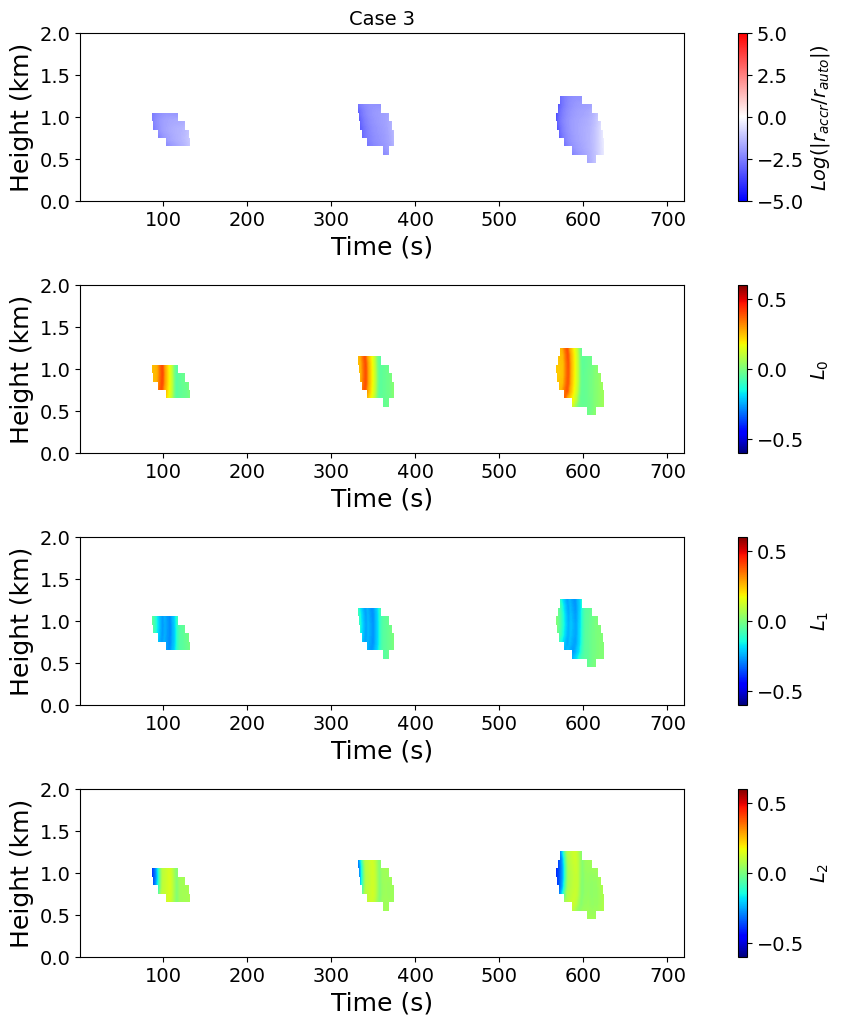

In [74]:
#visualize regimes in time/space for a specific case
moment = 1
nstart=2
cauto = ds2['cauto'][case,moment,nstart:,:]
caccr = ds2['caccr'][case,moment,nstart:,:]
ccoal = ds2['ccoal'][case,moment,nstart:,:]

auto = ds2['auto'][case,moment,nstart:,:]
accr = ds2['accr'][case,moment,nstart:,:]
coal = ds2['coal'][case,moment,nstart:,:]

rh = ds2['cliq_mom'][case,1,:,:]

vmi = -5
vma = 5

vmal = 0.6
vmil = -0.6

np.seterr(divide='ignore', invalid='ignore')
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(14,12))

SMALL_SIZE = 14
MEDIUM_SIZE = 14
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

ax0 = ax[0] #ax[0,0]
im0=ax0.imshow((np.log(np.abs(accr/auto))).T, aspect=100,cmap="bwr",vmin=vmi,vmax=vma,origin='lower',extent=[1,720,0,2])
ax0.set_title("Case {}".format(case))
ax0.set_xlabel("Time (s)", fontsize=18)
ax0.set_ylabel("Height (km)", fontsize=18)

ax1 = ax[1]
im1=ax1.imshow(plotvar[:,:,0].T, aspect=100,origin='lower',vmin=vmil,vmax=vmal,cmap="jet",extent=[1,720,0,2])
ax1.set_xlabel("Time (s)", fontsize=18)
ax1.set_ylabel("Height (km)", fontsize=18)

ax2 = ax[2] 
im2=ax2.imshow(plotvar[:,:,1].T, aspect=100,origin='lower',vmin=vmil,vmax=vmal,cmap="jet",extent=[1,720,0,2])
ax2.set_xlabel("Time (s)", fontsize=18)
ax2.set_ylabel("Height (km)", fontsize=18)

ax3 = ax[3]
im3=ax3.imshow(plotvar[:,:,2].T, aspect=100,origin='lower',vmin=vmil,vmax=vmal,cmap="jet",extent=[1,720,0,2])
ax3.set_xlabel("Time (s)", fontsize=18)
ax3.set_ylabel("Height (km)", fontsize=18)

fig.subplots_adjust(wspace=0.5,hspace=0.5)
fig.colorbar(im0, label=r"$Log(|r_{accr}/r_{auto}|)$",ax=ax0)
fig.colorbar(im1, label=r"$L_{0}$",ax=ax1)
fig.colorbar(im2, label=r"$L_{1}$",ax=ax2)
fig.colorbar(im3, label=r"$L_{2}$",ax=ax3)

#plt.savefig("RateRegimesMassCase3.png")